In [64]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds
import kagglehub
import os
import pandas as pd

In [65]:
# Path de imagens
DATA_DIR = 'data/images/raw'

# Download do dataset CBIS-DDSM do Kaggle
def download_breast_cancer_dataset():
    if os.path.exists(DATA_DIR) and os.listdir(DATA_DIR):
        files = os.listdir(DATA_DIR)
        has_data = any(
            f.endswith('.csv') or os.path.isdir(os.path.join(DATA_DIR, f)) 
            for f in files
        )
        
        if has_data:
            return DATA_DIR
    
    try:
        dataset_path = kagglehub.dataset_download("awsaf49/cbis-ddsm-breast-cancer-image-dataset")
        if os.path.exists(dataset_path):
            if os.path.isdir(dataset_path):
                files_count = len(os.listdir(dataset_path))
                if files_count > 0:
                    return dataset_path
                else:
                    return None
            else:
                return dataset_path
        else:
            return None
            
    except Exception as e:
        print(f"Erro ao baixar dataset: {e}")
        return None

dataset_path = download_breast_cancer_dataset()

if not dataset_path:
    print("Não foi possível obter o dataset. Verifique as mensagens acima.")


Vamos carregar apenas 10 imagens do dataset para um treino simples do CNN


In [ ]:
# Retorno de imagens do dataset
NUM_IMAGES = 30
IMG_SIZE = (384, 384)
def load_sample_images(dataset_path, num_images=NUM_IMAGES, img_size=IMG_SIZE):
    images = []
    labels = []
    image_extensions = ['.png', '.jpg', '.jpeg', '.dcm']
    image_files = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_files.append(os.path.join(root, file))
                if len(image_files) >= num_images * 2:
                    break
        if len(image_files) >= num_images * 2:
            break
    
    if len(image_files) < num_images:
        num_images = len(image_files)
    selected_files = image_files[:num_images]
    for i, img_path in enumerate(selected_files):
        try:
            # Carrega imagem com OpenCV
            img = cv2.imread(img_path)
            
            if img is None:
                # Tenta carregar como DICOM se for .dcm
                if img_path.endswith('.dcm'):
                    continue  # Pula DICOM por enquanto
                continue
            
            # Converte para escala de cinza
            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # Redimensiona para img_size
            img = cv2.resize(img, img_size)
            
            # Normaliza valores entre 0 e 1 
            img = img.astype('float32') / 255.0
            
            images.append(img)
            
            # Label simples: 0 para benigno, 1 para maligno
            if 'benign' in img_path.lower() or 'normal' in img_path.lower():
                labels.append(0)
            else:
                labels.append(1)
                
        except Exception as e:
            print(f"Erro ao carregar {img_path}: {e}")
            continue
    
    if len(images) == 0:
        print("Nenhuma imagem foi carregada com sucesso.")
        return None, None
    
    # Converte para arrays numpy
    images = np.array(images)
    labels = np.array(labels)
    
    # Adiciona dimensão de canal (384, 384) -> (384, 384, 1) para CNN
    if len(images.shape) == 3:
        images = np.expand_dims(images, axis=-1)
    
    print(f"{len(images)} de {NUM_IMAGES} imagens carregadas com sucesso!")
    print(f"Forma das imagens: {images.shape}")
    print(f"Forma dos labels: {labels.shape}")
    print(f"Distribuição: {np.bincount(labels)} (0=benigno, 1=maligno)")
    
    return images, labels

# Carrega imagens baseado em NUM_IMAGES
if dataset_path:
    X, y = load_sample_images(dataset_path, num_images=NUM_IMAGES, img_size=IMG_SIZE)
    print(f"\nTotal de imagens carregadas de {NUM_IMAGES}: {len(X) if X is not None else 0}")
else:
    print("Dataset não disponível")
    X, y = None, None


📥 Carregando 30 imagens...
30 de 30 imagens carregadas com sucesso!
Forma das imagens: (30, 384, 384, 1)
Forma dos labels: (30,)
Distribuição: [ 0 30] (0=benigno, 1=maligno)

Total de imagens carregadas de 30: 30


Abaixo a separação entre as imagens de treino e teste.


In [67]:
# Separação treino/teste (80/20)
if X is not None and y is not None:
    # Usa o número real de imagens carregadas
    total_images = len(X)
    
    # Cálculo de treino e teste (80/20)
    train_size = int(total_images * 0.8)  # 80% para treino
    test_size = total_images - train_size  # 20% para teste
    
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:]
    
    print(f"Total de imagens: {total_images}")
    print(f"Treino: {len(X_train)} imagens ({len(X_train)/total_images*100:.1f}%)")
    print(f"Teste: {len(X_test)} imagens ({len(X_test)/total_images*100:.1f}%)")
    print(f"Forma X_train: {X_train.shape}")
    print(f"Forma X_test: {X_test.shape}")
    
    # Define variáveis para treinamento baseadas no tamanho real
    NUM_TRAIN_IMAGES = len(X_train)
    NUM_TEST_IMAGES = len(X_test)
else:
    print("Dados não disponíveis para separação.")
    NUM_TRAIN_IMAGES = 0
    NUM_TEST_IMAGES = 0


Total de imagens: 30
Treino: 24 imagens (80.0%)
Teste: 6 imagens (20.0%)
Forma X_train: (24, 384, 384, 1)
Forma X_test: (6, 384, 384, 1)


Abaixo o modelo sequencial para rede neural convolucional com:
- Camadas convolucionais (Conv2D) com ReLU
- Camadas de MaxPooling
- Flatten
- Camadas Dense (fully connected)


In [68]:
# Criação do modelo CNN 
if X_train is not None:
    # Criou um modelo sequencial para rede neural convolucional
    model = models.Sequential()
    
    # Primeira camada convolucional com 32 filtros de tamanho 3x3 e função de ativação ReLU
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(384, 384, 1)))
    
    # Adiciona uma camada de max pooling 2x2 para reduzir a dimensionalidade
    model.add(layers.MaxPooling2D(2, 2))
    
    # Segunda camada convolucional com 64 filtros de tamanho 3x3 e função de ativação ReLU
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    # Adiciona uma segunda camada de max pooling
    model.add(layers.MaxPooling2D(2, 2))
    
    # Terceira camada convolucional com 64 filtros de tamanho 3x3 e ReLU
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    
    # Adiciona uma camada flatten para converter os mapas de características em um vetor
    model.add(layers.Flatten())
    
    # Adiciona uma camada totalmente conectada com 64 unidades e função de ativação ReLU
    model.add(layers.Dense(64, activation='relu'))
    
    # Adiciona uma camada de saída totalmente conectada com 2 unidades (benigno/maligno) 
    # e função de ativação softmax para classificação
    model.add(layers.Dense(2, activation='softmax'))
    
    # Resumo do modelo
    model.summary()
else:
    print("Dados não disponíveis para criar modelo.")


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 382, 382, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 191, 191, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 189, 189, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 94, 94, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 92, 92, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 541696)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │    34,668,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,724,482 (132.46 MB)

 Trainable params: 34,724,482 (132.46 MB)

 Non-trainable params: 0 (0.00 B)

Compilamos com ADAM por ser um otimizador mais popular, função de perda sparse_categorical_crossentropy e métrica accuracy.


In [69]:
# Compilação do modelo
if 'model' in locals():
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    print("Modelo compilado com sucesso!")
else:
    print("Erro ao compilar modelo")


Modelo compilado com sucesso!


Para configuração de EPOCHS:
- Baseado em `NUM_IMAGES` (número total de imagens a serem carregadas)
- Poucos dados (NUM_IMAGES < 50): 15 epochs (evita overfitting - decoração de dados)
- Dados moderados (50-200): 20 epochs
- Muitos dados (> 200): 30 epochs

Para configuração de BATCH SIZE
- Baseado em `NUM_IMAGES` usando proporção de 20%: `BATCH_SIZE = NUM_IMAGES * 0.2`
- Ajustado para valores razoáveis:
  - NUM_IMAGES ≤ 10: batch_size = 2
  - NUM_IMAGES ≤ 50: batch_size entre 2-4
  - NUM_IMAGES ≤ 200: batch_size entre 4-8
  - NUM_IMAGES > 200: batch_size entre 8-16

In [70]:
if 'model' in locals() and X_train is not None and 'NUM_IMAGES' in locals():
    if NUM_IMAGES < 50:
        NUM_EPOCHS = 15
    elif NUM_IMAGES < 200:
        NUM_EPOCHS = 20
    else:
        NUM_EPOCHS = 30

    # Calcula 20% de NUM_IMAGES
    BATCH_SIZE = int(NUM_IMAGES * 0.2) 
    
    # Ajusta de valores razoáveis   
    if NUM_IMAGES <= 10:
        BATCH_SIZE = 2
    elif NUM_IMAGES <= 50:
        BATCH_SIZE = max(2, min(BATCH_SIZE, 4))
    elif NUM_IMAGES <= 200:
        BATCH_SIZE = max(4, min(BATCH_SIZE, 8))
    else:
        BATCH_SIZE = max(8, min(BATCH_SIZE, 16))
    
    # Garante que batch_size não seja maior que o tamanho do treino
    if 'NUM_TRAIN_IMAGES' in locals():
        BATCH_SIZE = min(BATCH_SIZE, NUM_TRAIN_IMAGES)
    else:
        BATCH_SIZE = min(BATCH_SIZE, len(X_train) if X_train is not None else BATCH_SIZE)
    
    BATCH_SIZE = int(BATCH_SIZE)  # Converte para int
    
    # Calcula steps por época baseado no tamanho real do treino
    train_size = len(X_train) if X_train is not None else 0
    steps_per_epoch = train_size // BATCH_SIZE if BATCH_SIZE > 0 else 1
    
    history = model.fit(
        X_train, 
        y_train, 
        epochs=NUM_EPOCHS, 
        batch_size=BATCH_SIZE,
        validation_data=(X_test, y_test) if len(X_test) > 0 else None,
        verbose=1
    )
else:
    print("Erro ao treinar modelo")


Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.9167 - loss: 0.1314 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.00

A avaliação, análise dos dados retornados, gráficos para validação de treinamento, predições e análise visual.


Acurácia no teste: 1.0000
Loss no teste: 0.0000
Número de imagens de teste: 6

Predições (6 imagens):
Real=Maligno, Predito=Maligno (100.0%)
Real=Maligno, Predito=Maligno (100.0%)
Real=Maligno, Predito=Maligno (100.0%)
Real=Maligno, Predito=Maligno (100.0%)
Real=Maligno, Predito=Maligno (100.0%)
Real=Maligno, Predito=Maligno (100.0%)


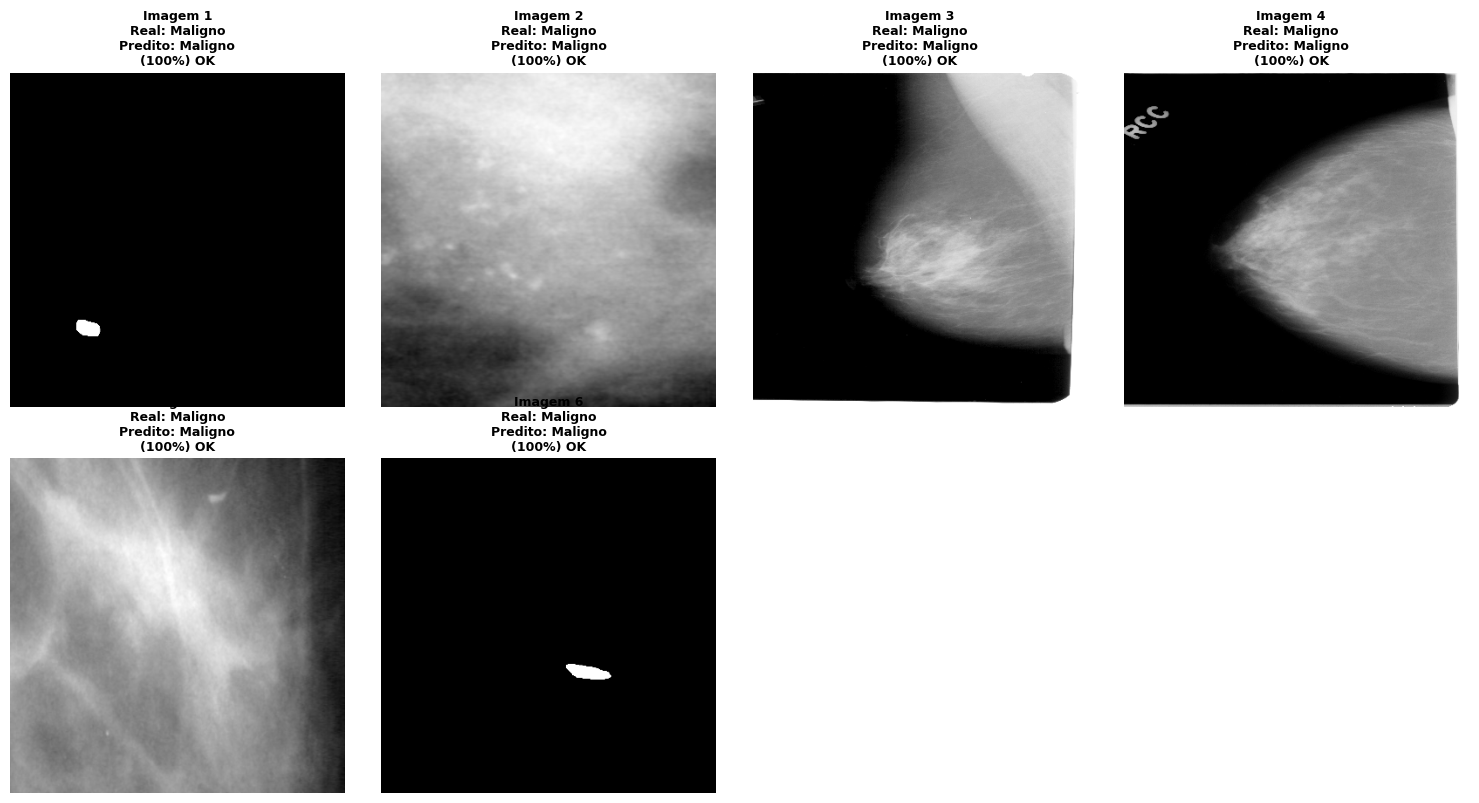

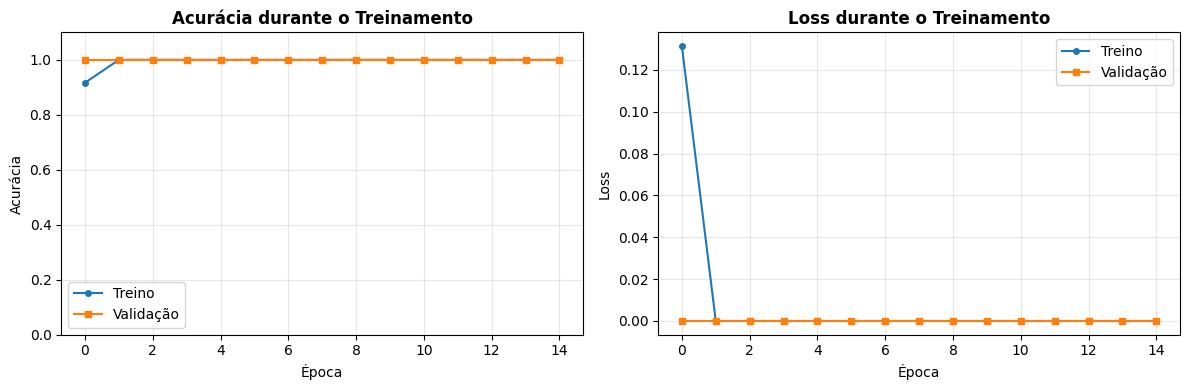


💡 Análise: O gráfico mostra a evolução do treinamento.
💡 Overfitting = decorou os dados (gap grande entre treino e validação)

Estatísticas finais:
Acurácia treino: 1.0000
Acurácia validação: 1.0000
Diferença: 0.0000


In [ ]:
# Avaliação e visualização (conforme Aula 4)
if 'model' in locals() and X_test is not None and len(X_test) > 0:
    num_test_images = len(X_test)
    
    # Avaliação do modelo
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Acurácia no teste: {test_accuracy:.4f}")
    print(f"Loss no teste: {test_loss:.4f}")
    print(f"Número de imagens de teste: {num_test_images}")
    
    # Predições
    predictions = model.predict(X_test, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    
    print(f"\nPredições ({num_test_images} imagens):")
    for i in range(num_test_images):
        true_label = "Benigno" if y_test[i] == 0 else "Maligno"
        pred_label = "Benigno" if predicted_classes[i] == 0 else "Maligno"
        confidence = predictions[i][predicted_classes[i]] * 100
        print(f"Real={true_label}, Predito={pred_label} ({confidence:.1f}%)")
    
    # Ajusta o layout baseado no número de imagens
    if num_test_images == 1:
        # Uma única imagem: exibe maior
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.imshow(X_test[0].squeeze(), cmap='gray')
        true_label = "Benigno" if y_test[0] == 0 else "Maligno"
        pred_label = "Benigno" if predicted_classes[0] == 0 else "Maligno"
        confidence = predictions[0][predicted_classes[0]] * 100
        status = "Correto" if y_test[0] == predicted_classes[0] else "Errado"
        ax.set_title(f"Real: {true_label}\nPredito: {pred_label}\nConfiança: {confidence:.1f}%\n{status}", 
                    fontsize=12, fontweight='bold')
        ax.axis('off')
    elif num_test_images <= 4:
        # Poucas imagens: exibe em linha
        fig, axes = plt.subplots(1, num_test_images, figsize=(4*num_test_images, 4))
        if num_test_images == 1:
            axes = [axes]
        for i in range(num_test_images):
            axes[i].imshow(X_test[i].squeeze(), cmap='gray')
            true_label = "Benigno" if y_test[i] == 0 else "Maligno"
            pred_label = "Benigno" if predicted_classes[i] == 0 else "Maligno"
            confidence = predictions[i][predicted_classes[i]] * 100
            status = "OK" if y_test[i] == predicted_classes[i] else "ERRO"
            axes[i].set_title(f"Real: {true_label}\nPredito: {pred_label}\n({confidence:.0f}%) {status}", 
                            fontsize=10, fontweight='bold')
            axes[i].axis('off')
    elif num_test_images <= 12:
        # Múltiplas imagens: exibe em grid 2xN ou 3xN
        cols = 4
        rows = (num_test_images + cols - 1) // cols  # Arredonda para cima
        fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
        axes = axes.flatten() if rows > 1 else [axes] if cols == 1 else axes
        
        for i in range(num_test_images):
            axes[i].imshow(X_test[i].squeeze(), cmap='gray')
            true_label = "Benigno" if y_test[i] == 0 else "Maligno"
            pred_label = "Benigno" if predicted_classes[i] == 0 else "Maligno"
            confidence = predictions[i][predicted_classes[i]] * 100
            status = "OK" if y_test[i] == predicted_classes[i] else "ERRO"
            axes[i].set_title(f"Imagem {i+1}\nReal: {true_label}\nPredito: {pred_label}\n({confidence:.0f}%) {status}", 
                            fontsize=9, fontweight='bold')
            axes[i].axis('off')
        
        # Esconde eixos vazios
        for i in range(num_test_images, len(axes)):
            axes[i].axis('off')
    else:
        # Muitas imagens: exibe apenas as primeiras 12
        print(f"⚠️ Exibindo apenas as primeiras 12 de {num_test_images} imagens")
        cols = 4
        rows = 3
        fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
        axes = axes.flatten()
        
        for i in range(min(12, num_test_images)):
            axes[i].imshow(X_test[i].squeeze(), cmap='gray')
            true_label = "Benigno" if y_test[i] == 0 else "Maligno"
            pred_label = "Benigno" if predicted_classes[i] == 0 else "Maligno"  
            axes[i].set_title(f"Imagem {i+1}\nReal: {true_label}\nPredito: {pred_label}", 
                            fontsize=9, fontweight='bold')
            axes[i].axis('off')
        
        # Esconde eixos vazios
        for i in range(12, len(axes)):
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Gráficos para validação de treinamento (se houver histórico)
    if 'history' in locals():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Gráfico de accuracy
        ax1.plot(history.history['accuracy'], label='Treino', marker='o', markersize=4)
        if 'val_accuracy' in history.history:
            ax1.plot(history.history['val_accuracy'], label='Validação', marker='s', markersize=4)
        ax1.set_title('Acurácia durante o Treinamento', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Época')
        ax1.set_ylabel('Acurácia')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        ax1.set_ylim([0, 1.1])
        
        # Gráfico de loss
        ax2.plot(history.history['loss'], label='Treino', marker='o', markersize=4)
        if 'val_loss' in history.history:
            ax2.plot(history.history['val_loss'], label='Validação', marker='s', markersize=4)
        ax2.set_title('Loss durante o Treinamento', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Época')
        ax2.set_ylabel('Loss')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Estatísticas adicionais
        if 'val_accuracy' in history.history:
            final_train_acc = history.history['accuracy'][-1]
            final_val_acc = history.history['val_accuracy'][-1]
            gap = abs(final_train_acc - final_val_acc)
            print(f"\nEstatísticas finais:")
            print(f"Acurácia treino: {final_train_acc:.4f}")
            print(f"Acurácia validação: {final_val_acc:.4f}")
            print(f"Diferença: {gap:.4f}")
else:
    print("Dados não disponíveis para avaliação.")
